True

In [5]:
import operator
import os
import random
from typing import Annotated, Sequence, TypedDict

from dotenv import load_dotenv
from IPython.display import Image
from langchain_core.messages import (BaseMessage, HumanMessage, SystemMessage,
                                     ToolMessage)
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langgraph.graph import END, MessageGraph, StateGraph
from pptx import Presentation
from pptx_tools import create_pptx_presentation, save_pptx_presentation

load_dotenv()

llm = ChatOpenAI()

In [43]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # api_call_count: int = 0
    bullet_points: Annotated[Sequence[str], operator.add]

In [44]:
# @tool
# def fake_weather_api(city: str) -> str:
#     """Returns the weather for a given city."""
#     if random.randint(0, 2) == 1:
#         return f"Sunny, {random.randint(10, 30)} degrees"
#     else:
#         return "Service unavailable"
    

@tool
def create_bullet_point_text(topic: str) -> str:
    """Creates a bullet point text for a given topic."""
    return "Fake bullet point text"


llm_with_tools = llm.bind_tools([create_bullet_point_text])

tool_mapping = {
    # "fake_weather_api": fake_weather_api,
    "create_bullet_point_text": create_bullet_point_text,
}


In [91]:
def should_continue(state: AgentState):
    print("--> should_continue")
    bullet_points = state["bullet_points"]
    messages = state["messages"]
    last_message = messages[-1]
    
    has_tool_calls = True if len(last_message.tool_calls) > 0 else False
    print("has_tool_calls: ", has_tool_calls)   
    
    if len(bullet_points) >= 3:
        print("NO")
        print(bullet_points)
        return "end"
    else:
        print("YES")
        return "continue"
    

def call_model(state: AgentState):
    print("--> call_model")
    print("state: ", state)
    messages = state["messages"]
    print("messages: ", messages)
    response = llm_with_tools.invoke(messages)
    print("Response: ", response)
    return {
        "messages": [response],
        "bullet_points": state["bullet_points"],
    }


def create_bullet_point(state: AgentState):
    print("--> create_bullet_point")
    bullet_points = state["bullet_points"]
    print("bullet_points: ", bullet_points)
    messages = state["messages"]
    print("messages: ", messages)
    last_message = messages[-1]
    print("last_message: ", last_message)


    if last_message.tool_calls:
        print("Tool call in message")
        tool_call = last_message.tool_calls[0]
        print("tool_call: ", tool_call)
        tool_name = tool_call["name"].lower()
        print(f"Tool name: {tool_name} ({tool_call["args"]})")
        tool = tool_mapping[tool_name]
        tool_output = tool.invoke(tool_call["args"])
        print("Tool output: ", tool_output)
        tool_message = ToolMessage(content=tool_output, tool_call_id=tool_call["id"])

        return {
            "messages": [tool_message],
            "bullet_points": [tool_message.content],
        }
    return {
        "messages": state["messages"],
        "bullet_points": state["bullet_points"],
    }
    





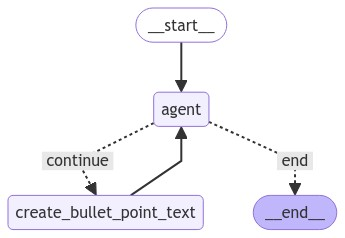

In [92]:

workflow = StateGraph(AgentState)

workflow.add_node("agent", call_model)
# workflow.add_node("action", call_tool)
workflow.add_node("create_bullet_point_text", create_bullet_point)
workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue": "create_bullet_point_text",
        "end": END
    },
)
workflow.add_edge("create_bullet_point_text", "agent")
workflow.set_entry_point("agent")

app = workflow.compile()
Image(app.get_graph().draw_mermaid_png())

In [93]:
system_message = SystemMessage(content="""You are a content writer. You are responsible for writing bullet points about a topic for a presentation. 
                               You use tools for that. Continue until you have 3 bullet points.""")
human_message = HumanMessage(content="Danish Early History")
messages = [system_message, human_message]

r = app.invoke({"messages": messages})

--> call_model
state:  {'messages': [SystemMessage(content='You are a content writer. You are responsible for writing bullet points about a topic for a presentation. \n                               You use tools for that. Continue until you have 3 bullet points.'), HumanMessage(content='Danish Early History')], 'bullet_points': []}
messages:  [SystemMessage(content='You are a content writer. You are responsible for writing bullet points about a topic for a presentation. \n                               You use tools for that. Continue until you have 3 bullet points.'), HumanMessage(content='Danish Early History')]
Response:  content='' additional_kwargs={'tool_calls': [{'id': 'call_th0SvDXgeiWaGLQIeNjUkf3H', 'function': {'arguments': '{"topic": "Introduction of Danes to Denmark"}', 'name': 'create_bullet_point_text'}, 'type': 'function'}, {'id': 'call_Bdzmz2NUehOSHRIrwgiSEx3m', 'function': {'arguments': '{"topic": "Viking Age in Denmark"}', 'name': 'create_bullet_point_text'}, 'type':

BadRequestError: Error code: 400 - {'error': {'message': "An assistant message with 'tool_calls' must be followed by tool messages responding to each 'tool_call_id'. The following tool_call_ids did not have response messages: call_Bdzmz2NUehOSHRIrwgiSEx3m, call_EUqjfnPWxDUZHIdAwrEKOP28", 'type': 'invalid_request_error', 'param': 'messages', 'code': None}}